## Necessary Imports

In [1]:
import math
import os
import json

import tensorflow as tf
import tensorflow.keras as keras

import librosa

import numpy as np
import seaborn as sns
import pandas as pd

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier

2022-04-20 23:37:33.225810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Helper Function Definitions

In [2]:
def print_report(y_test, y_pred):
  print("Accuracy Score is:\t {0:.3f}".format(accuracy_score(y_test, y_pred)))
  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

In [3]:
def load_data(data_path):
    
    with open(data_path,"r") as fp:
        data = json.load(fp)
    
    genres = data['mapping']
    x = np.array(data['mfcc'])
    y = np.array(data["labels"])
    
    return genres, x, y

In [4]:
def plot_history(history):
    
    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [5]:
def prepare_datasets(X_train, y_train, validation_size):
    ##### CNN Specific Dataloader #####
    
    # create train, validation and test split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]

    return X_train, X_val, y_train, y_val

In [6]:
def replace_intermediate_layer_in_keras(model, layer_id, new_layer):
    
    layers = [l for l in model.layers]

    x = layers[0].output
    for i in range(1, len(layers)):
        if i == layer_id:
            x = new_layer(x)
        else:
            x = layers[i](x)

    new_model = keras.models.Model(layers[0].input, x)
    return new_model

In [7]:
def predict_genre(model, song_mfcc, y_true):
    """
    Given a song, predict it's label (using a keras model)
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    song_mfcc = song_mfcc[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(song_mfcc)

    # get index with max value
    y_pred = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y_true, y_pred))

## Load Data & Develop Test/Train Splits

In [8]:
FMA_JSON_PATH = "/storage/graham/music/fma_small_data.json"
GTZAN_JSON_PATH = "/storage/graham/music/gtzan_data.json"
MODEL_PATH = "/storage/graham/music/models/"

GTZAN_SAMPLE_RATE = 22050  # gtzan sample rate
FMA_SAMPLE_RATE = GTZAN_SAMPLE_RATE * 2  # fma sample rate
DURATION = 30  # measure in seconds

In [9]:
%%time
genres, X, y = load_data(GTZAN_JSON_PATH)

CPU times: user 10.3 s, sys: 903 ms, total: 11.2 s
Wall time: 11.2 s


In [10]:
SPLIT = 0.3

# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT)

# reshape MFCC to be a vector
X_train_vec = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test_vec = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

X_vec = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

## Data Visualization with t-SNE

In [11]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(X_vec)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9986 samples in 0.049s...


/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:94: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:110: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn("The default learning rate in TSNE will change "


[t-SNE] Computed neighbors for 9986 samples in 0.461s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9986
[t-SNE] Computed conditional probabilities for sample 2000 / 9986
[t-SNE] Computed conditional probabilities for sample 3000 / 9986
[t-SNE] Computed conditional probabilities for sample 4000 / 9986
[t-SNE] Computed conditional probabilities for sample 5000 / 9986
[t-SNE] Computed conditional probabilities for sample 6000 / 9986
[t-SNE] Computed conditional probabilities for sample 7000 / 9986
[t-SNE] Computed conditional probabilities for sample 8000 / 9986
[t-SNE] Computed conditional probabilities for sample 9000 / 9986
[t-SNE] Computed conditional probabilities for sample 9986 / 9986
[t-SNE] Mean sigma: 255.320316
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.705360
[t-SNE] KL divergence after 1000 iterations: 2.182758
CPU times: user 1h 51min 58s, sys: 3min 45s, total: 1h 55min 44s
Wall time: 35.7 s


<Figure size 1728x1296 with 0 Axes>

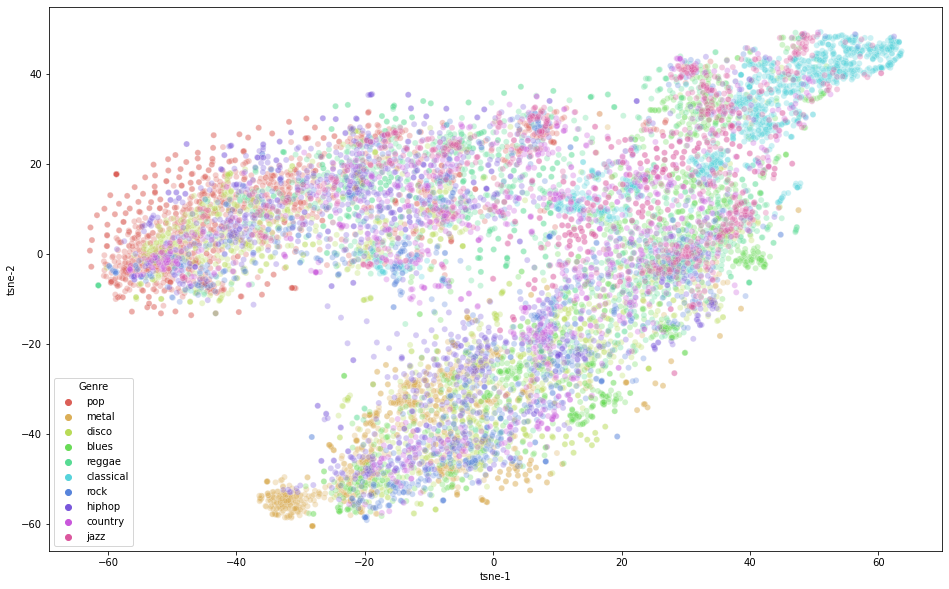

In [12]:
df_subset=pd.DataFrame()
df_subset['tsne-1'] = tsne_results[:,0]
df_subset['tsne-2'] = tsne_results[:,1]

# apply labels
labs = [genres[x] for x in y]
df_subset['Genre'] = labs

plt.figure(figsize=(24,18))
plt.figure(figsize=(16,10))
sns.scatterplot(x='tsne-1', 
                y='tsne-2',
                hue='Genre',
                palette=sns.color_palette('hls', len(genres)), 
                data=df_subset, 
                legend='full', 
                alpha=0.3
)
plt.show()

## Train Classical Models

### K-Nearest Neighbors Classifier

In [13]:
%%time
KNNmodel = KNeighborsClassifier(n_neighbors=10)
KNNmodel.fit(X_train_vec,y_train)
y_pred_knn = KNNmodel.predict(X_test_vec)

print_report(y_test, y_pred_knn)

Accuracy Score is:	 0.395
              precision    recall  f1-score   support

           0       0.65      0.31      0.42       307
           1       0.41      0.92      0.57       297
           2       0.53      0.17      0.25       296
           3       0.69      0.25      0.37       302
           4       0.89      0.05      0.10       305
           5       0.55      0.98      0.70       286
           6       0.30      0.27      0.29       304
           7       0.83      0.07      0.13       283
           8       0.25      0.30      0.27       301
           9       0.25      0.64      0.36       315

    accuracy                           0.40      2996
   macro avg       0.54      0.40      0.35      2996
weighted avg       0.53      0.40      0.35      2996

[[ 95   7  22   0   0   8  17   0  81  77]
 [  0 273   0   4   0   0   8   0   0  12]
 [ 12  82  49   1   1  13  39   1  46  52]
 [  0  76   2  76   0  27  33   0  13  75]
 [ 10  33   6   7  16  14  22   2  36 159]


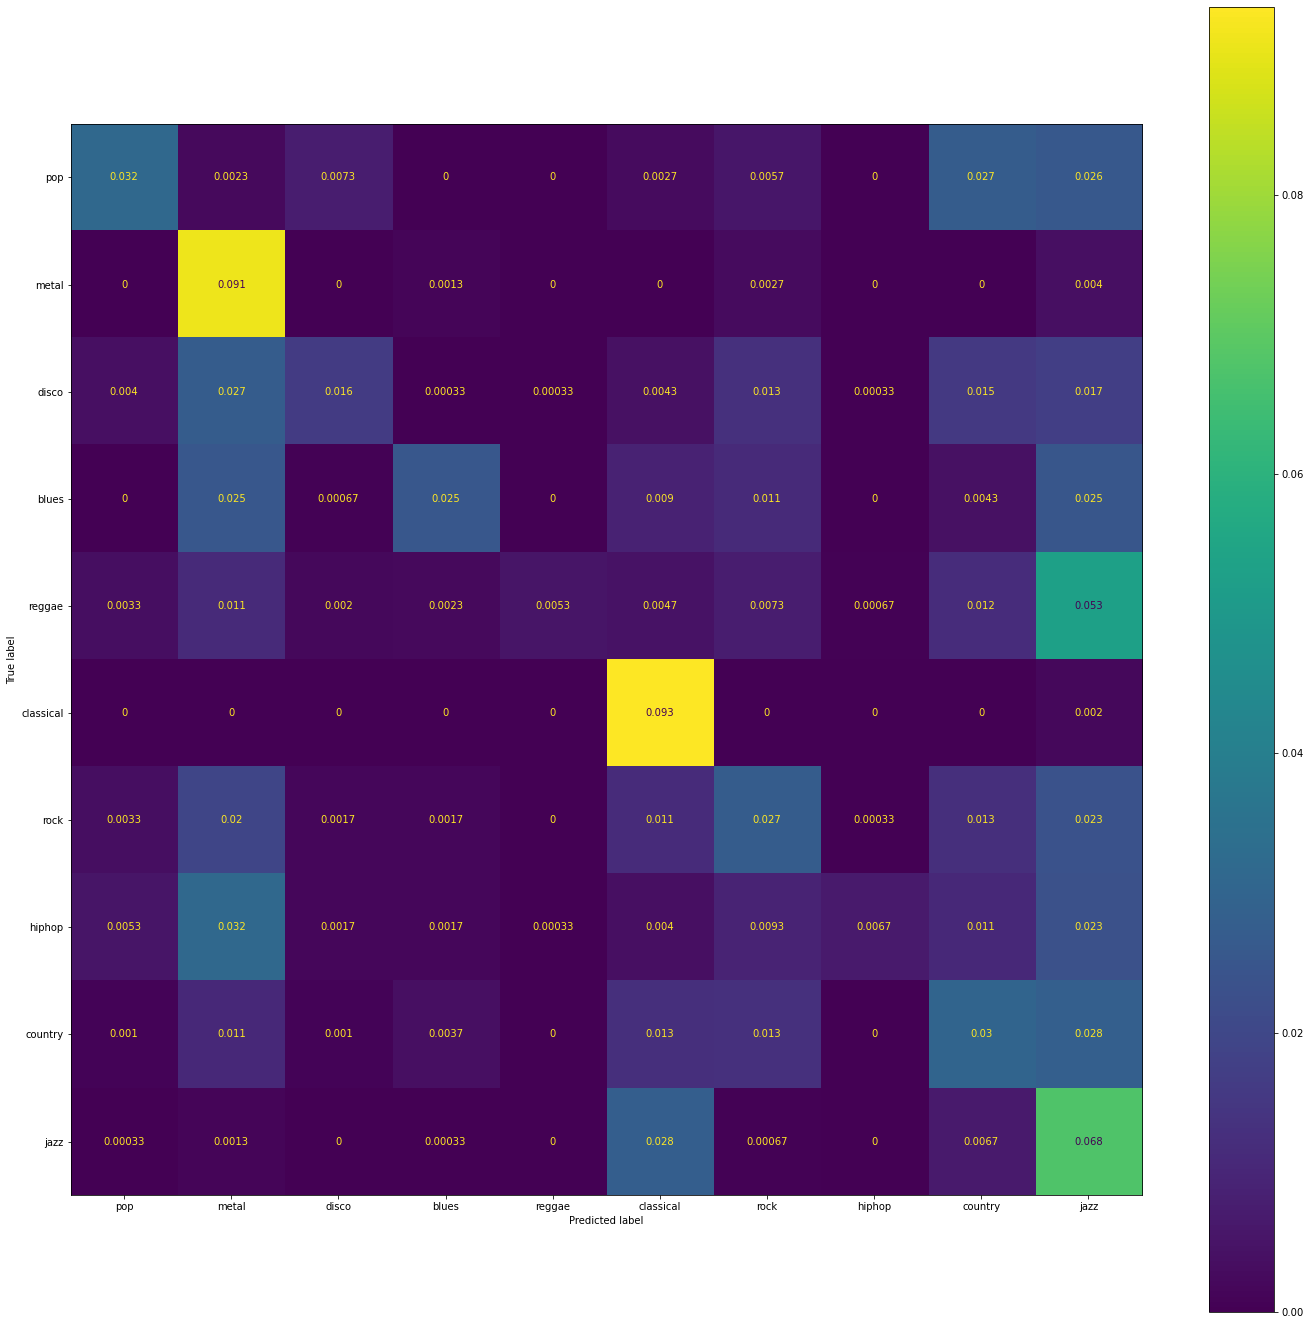

In [14]:
cm = confusion_matrix(y_test, y_pred_knn, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Support Vector Machine Classifier

In [15]:
%%time
SVMmodel = SVC()
SVMmodel.fit(X_train_vec,y_train)
y_pred_svm =  SVMmodel.predict(X_test_vec)

print_report(y_test, y_pred_svm)

Accuracy Score is:	 0.549
              precision    recall  f1-score   support

           0       0.57      0.83      0.68       307
           1       0.66      0.82      0.73       297
           2       0.41      0.38      0.40       296
           3       0.48      0.40      0.43       302
           4       0.50      0.50      0.50       305
           5       0.82      0.93      0.87       286
           6       0.36      0.29      0.32       304
           7       0.48      0.35      0.41       283
           8       0.50      0.35      0.41       301
           9       0.58      0.65      0.61       315

    accuracy                           0.55      2996
   macro avg       0.53      0.55      0.53      2996
weighted avg       0.53      0.55      0.53      2996

[[255   0  11   0  10   2   2   7  10  10]
 [  0 245   3   9   9   0  15  15   0   1]
 [ 62  19 113  17  19   2  34  24   5   1]
 [  0  47  14 120   7   8  52   0  23  31]
 [ 25   4  25  15 151   2   6  43  18  16]


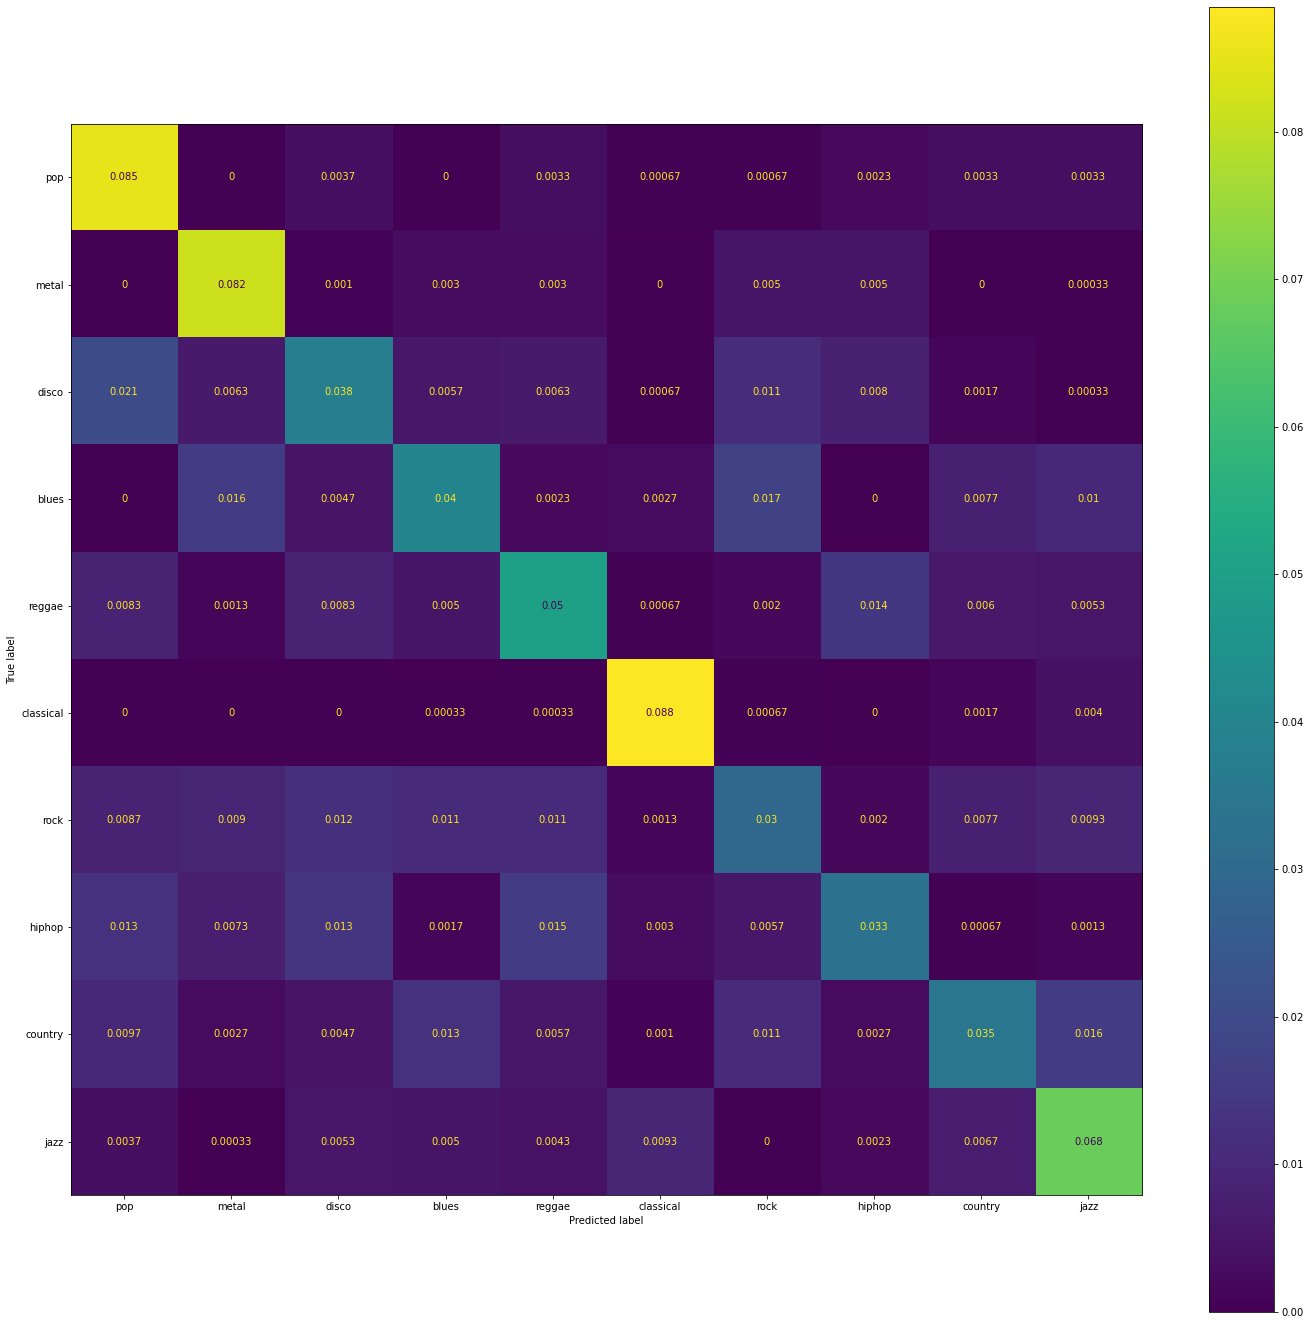

In [16]:
cm = confusion_matrix(y_test, y_pred_svm, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Decision Tree Classifier

In [17]:
%%time
DTmodel = DecisionTreeClassifier()
DTmodel.fit(X_train_vec, y_train)
y_pred_dt =  DTmodel.predict(X_test_vec)

print_report(y_test, y_pred_dt)

Accuracy Score is:	 0.350
              precision    recall  f1-score   support

           0       0.53      0.46      0.49       307
           1       0.57      0.56      0.57       297
           2       0.26      0.29      0.27       296
           3       0.32      0.28      0.30       302
           4       0.28      0.28      0.28       305
           5       0.65      0.64      0.65       286
           6       0.14      0.15      0.15       304
           7       0.26      0.24      0.25       283
           8       0.19      0.22      0.20       301
           9       0.38      0.39      0.38       315

    accuracy                           0.35      2996
   macro avg       0.36      0.35      0.35      2996
weighted avg       0.36      0.35      0.35      2996

[[141   0  29   2  34   5  31  30  25  10]
 [  1 167  23  21  11   2  34  20  17   1]
 [ 28  16  86  17  18   2  45  30  36  18]
 [  4  36  28  85  24  12  36  18  32  27]
 [ 24   3  32  22  85  13  33  22  42  29]


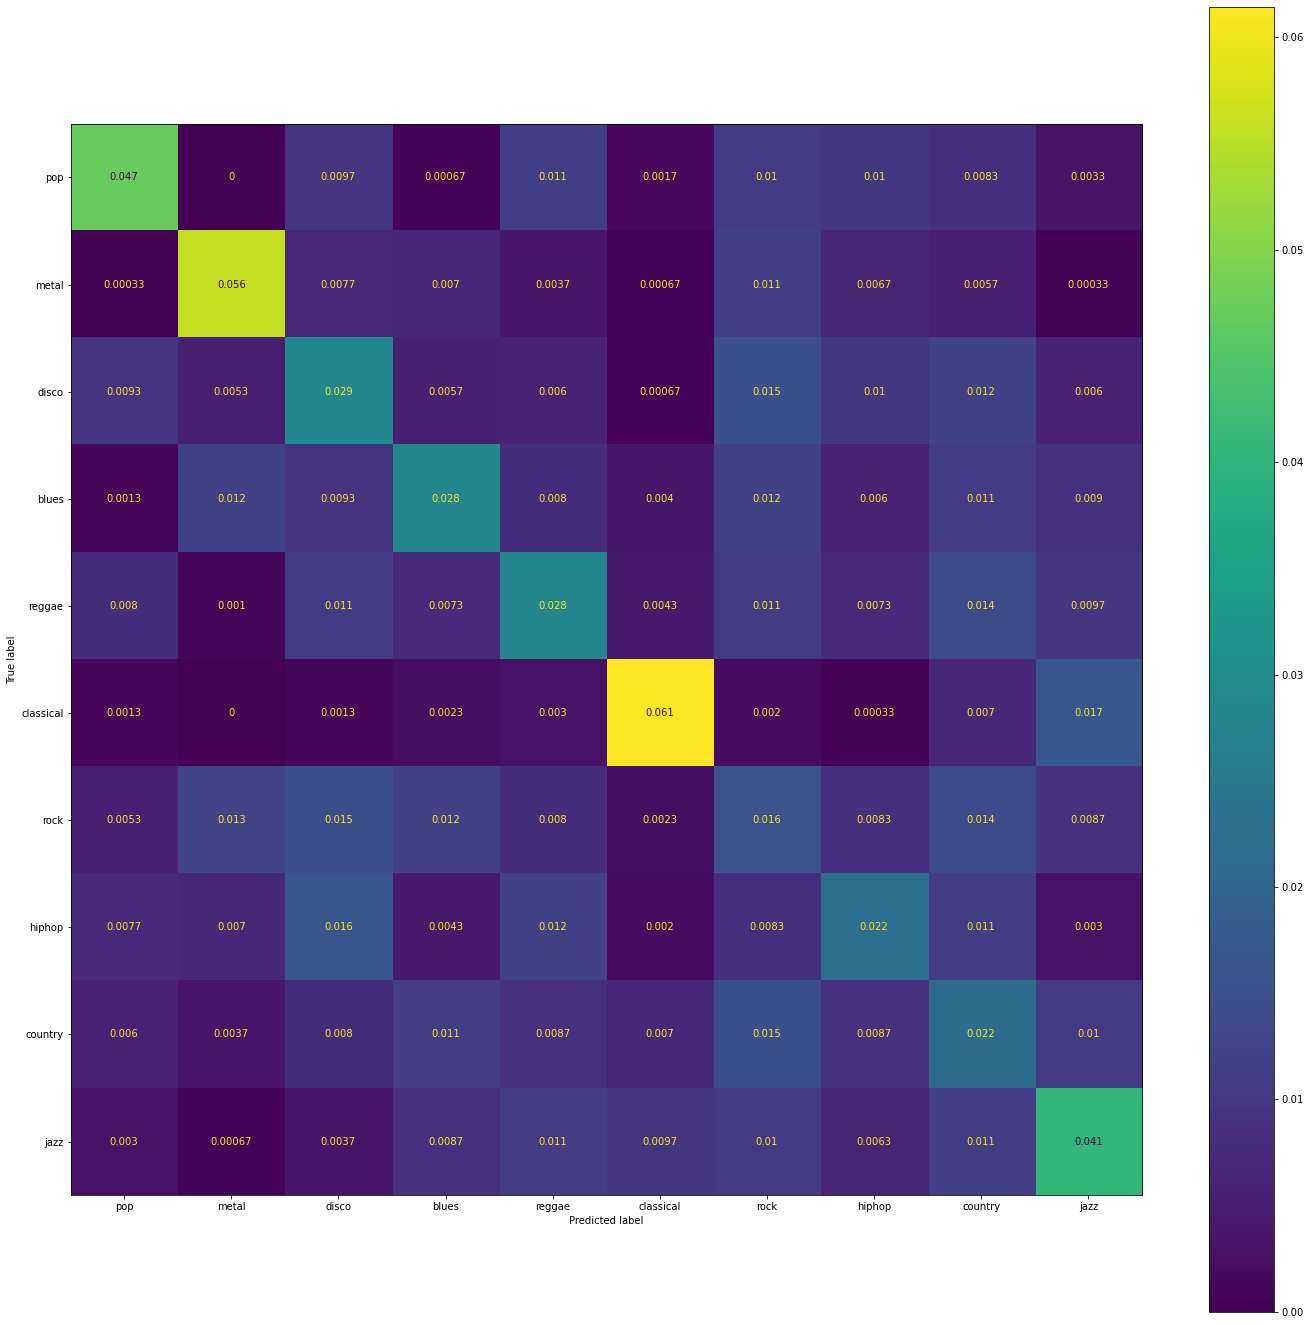

In [18]:
cm = confusion_matrix(y_test, y_pred_dt, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Gradient Boosted Classifier

In [19]:
%%time
XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_vec, y_train)
y_pred_xgb =  XGBmodel.predict(X_test_vec)

print_report(y_test, y_pred_xgb)

/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:38:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score is:	 0.612
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       307
           1       0.73      0.79      0.76       297
           2       0.48      0.51      0.49       296
           3       0.65      0.55      0.60       302
           4       0.54      0.51      0.53       305
           5       0.82      0.94      0.87       286
           6       0.47      0.46      0.46       304
           7       0.51      0.43      0.46       283
           8       0.48      0.44      0.46       301
           9       0.66      0.71      0.69       315

    accuracy                           0.61      2996
   macro avg       0.61      0.61      0.61      2996
weighted avg     

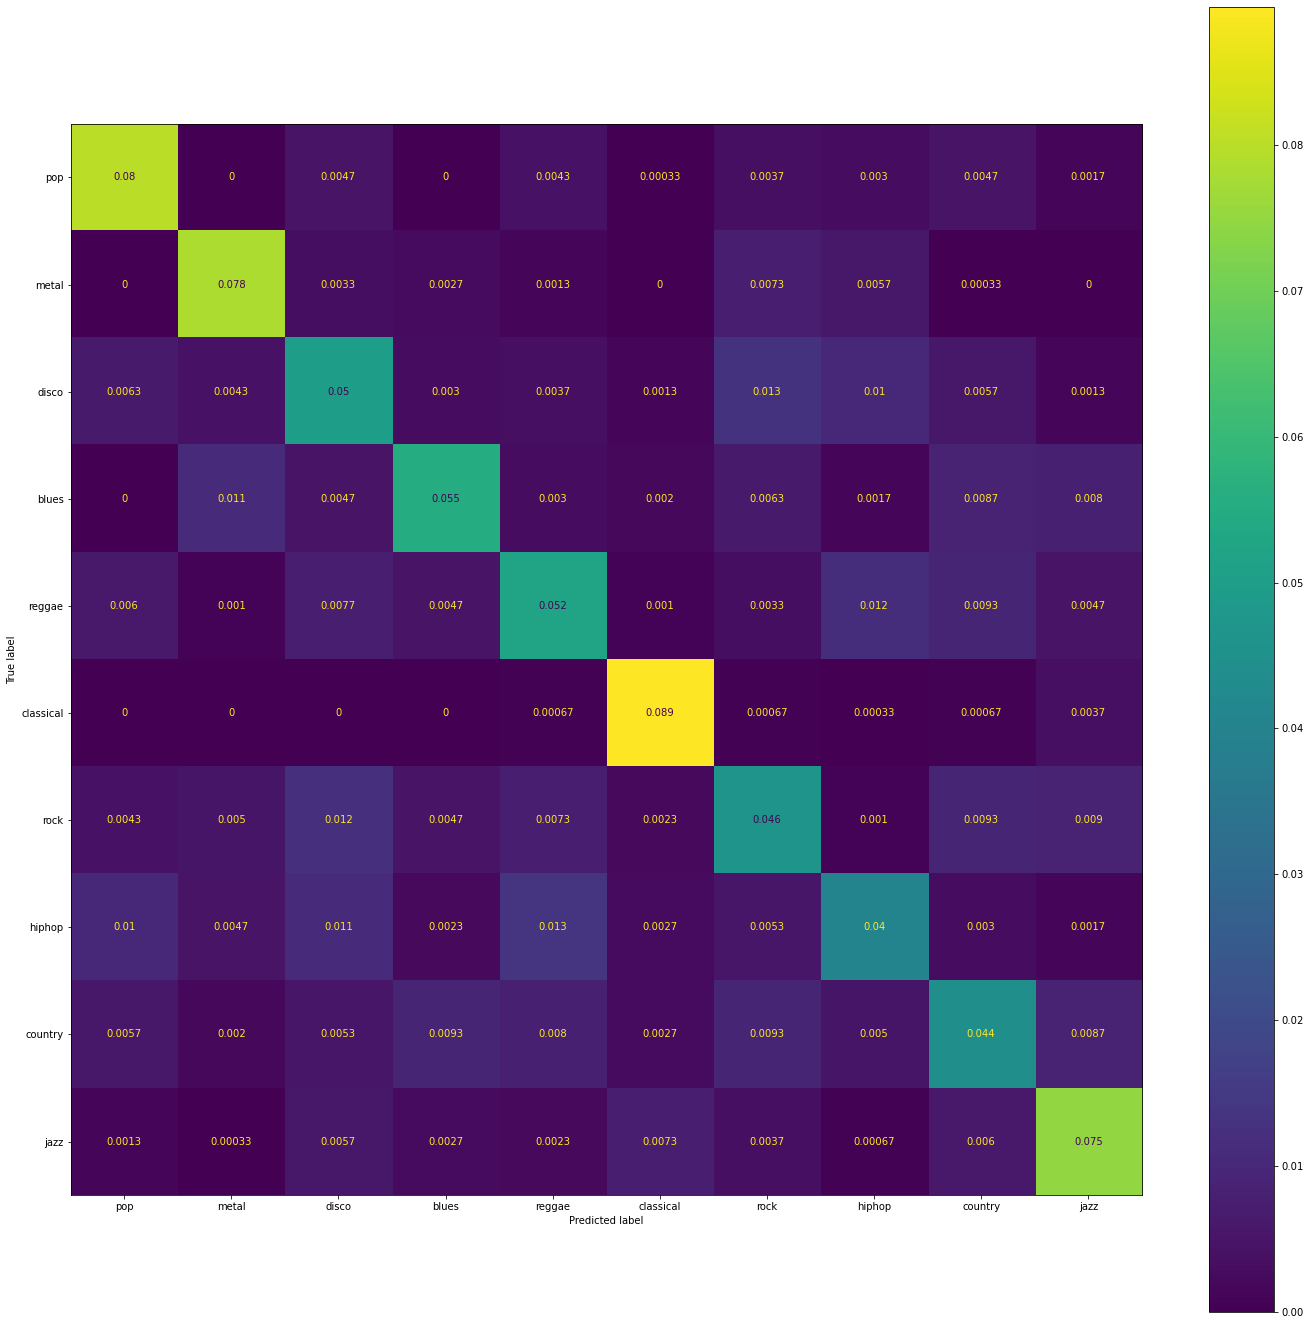

In [20]:
cm = confusion_matrix(y_test, y_pred_xgb, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

## Deep Learning Methods

### Fully Connected Neural Network (Multi-Layer Perceptron)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

219/219 [==============================] - 1s 6ms/step - loss: 2.5155 - accuracy: 0.3003 - val_loss: 2.5556 - val_accuracy: 0.3104
Epoch 48/100
219/219 [==============================] - 1s 6ms/step - loss: 2.4951 - accuracy: 0.3046 - val_loss: 2.5160 - val_accuracy: 0.3097
Epoch 49/100
219/219 [==============================] - 1s 6ms/step - loss: 2.4712 - accuracy: 0.2997 - val_loss: 2.4914 - val_accuracy: 0.3101
Epoch 50/100
219/219 [==============================] - 1s 6ms/step - loss: 2.4493 - accuracy: 0.3147 - val_loss: 2.4849 - val_accuracy: 0.2964
Epoch 51/100
219/219 [==============================] - 1s 6ms/step - loss: 2.4108 - accuracy: 0.3123 - val_loss: 2.4640 - val_accuracy: 0.3037
Epoch 52/100
219/219 [==============================] - 1s 6ms/step - loss: 2.3860 - accuracy: 0.3136 - val_loss: 2.4551 - val_accuracy: 0.3138
Epoch 53/100
219/219 [==============================] - 1s 6ms/step - loss: 2.3740 - accuracy: 0.3129 - val_loss: 2.4100 - val_accuracy: 0.3211
Epoch

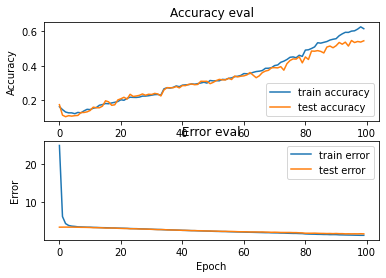

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


CPU times: user 2h 19min 21s, sys: 18min 31s, total: 2h 37min 52s
Wall time: 2min 24s


In [21]:
%%time
# build network topology
mlp = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(len(genres), activation='softmax')
])

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
mlp.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

mlp.summary()

# train model
history = mlp.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

# plot accuracy and error as a function of the epochs
plot_history(history)

# evaluate model on test set
test_loss, test_acc = mlp.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# save model
mlp.save(MODEL_PATH + "/gtzan_mlp/")

## Convolutional Neural Network Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                      

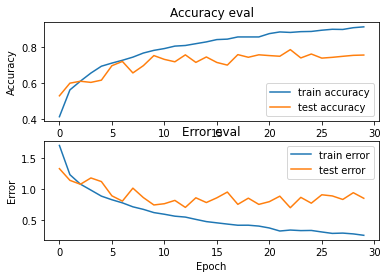

94/94 - 0s - loss: 0.3706 - accuracy: 0.8942 - 384ms/epoch - 4ms/step

Test accuracy: 0.8941922783851624
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


In [22]:
# get train, validation, test splits
X_train, X_val, y_train, y_val = prepare_datasets(X, y, 0.3)

### Build CNN Model ###
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# build network topology
cnn = keras.Sequential()

# 1st conv layer
cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(64, activation='relu'))
cnn.add(keras.layers.Dropout(0.3))

# output layer
cnn.add(keras.layers.Dense(len(genres), activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn.summary()

# train model
history = cnn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=30)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# save model
cnn.save(MODEL_PATH + "/gtzan_cnn/")